## Lab 10, Part 1:   Convolutional Neural Networks (CNN) 

In this lab, we will learn how to train CNNs. All the code is provided. The code is allowing you to prepare the data and train a CNN that classifies which digit is written in an image provided at its input. We will show how you can train 4 different CNN, ranging from simple to more complex, and let you observe how it impacts classification accuracy. 

### MNIST Data Set

MNIST is a dataset of hand-written digits. Size of each image is 28 by 28 pixels, where each pixel has values between 0 (white) and 255 (black). 

CNN training can take quite a bit of time (particularly if GPU isn't used), so we will create a training data set that uses a subset of available data. In particular, we will define the classification problem as recognizing whether a digit in an image is 7 or not. The following piece of code shows the data preparation steps.

In [74]:
#Import the required libraries
import numpy as np

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD;

The following block selects a subset of images from the MNIST data.

In [75]:
#Load the training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test_orig = X_test

# Select the subset from the train data for the sake of time.
np.random.seed(1338)  # for reproducibilty!!
# The subset is composed of all the examples where the digit is 7, and 20,000 examples are not 7.
sevens = np.where(y_train == 7)[0].tolist()
not_sevens = np.where(y_train != 7)[0].tolist()
num_keepers = 20000
not_sevens = np.random.choice(not_sevens, num_keepers, replace=False).tolist()

subset = sevens + not_sevens
np.random.shuffle(subset) # shuffle the input

X_train = X_train[subset, :, :]
y_train = y_train[subset]

The following code creates training and test data. It would be great if you can spend a few minutes trying to understand what is going on.

In [76]:
from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Create labels:

# Converting the labels to binary classification(Seven =1,Not Seven=0)
Y_train = (y_train == 7).astype(int)
Y_test = (y_test == 7).astype(int)

# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

**Question 1.** What are the dimensions of X_train, X_test, Y_train and Y_test? What are ranges of numbers in each of those?

In [77]:
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(26265, 28, 28, 1)
(10000, 28, 28, 1)
(26265, 2)
(10000, 2)


### Train a simple CNN (CNN, model 1)

The following code will show how you can define CNN, train it, and test its accuracy. 

**Step 0.** The following is a preparation step, specifying the hyperparameters.

In [78]:
#(below) sends 64 instances to GPU becuase the CPU doesnt have enough parallel capabilities

In [79]:
# -- Initializing the values for the convolution neural network

nb_epoch = 2  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) #stocatic g desent 

**Step 1.** In this step we define architecture of the CNN

Each line "model.add()" adds another layer to the neural network. The type of layer must be specified. 

In [80]:
model = Sequential()

#fist layer is below it is a convolusional layer
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
#adds Relu layer
model.add(Activation('relu'))
#adds maxPool layer
model.add(MaxPooling2D(pool_size=(26, 26)))
#does soemthing wasnt clear
model.add(Flatten())
#adds a dense with the number of classes (not clea ron this)
model.add(Dense(nb_classes))

model.add(Activation('softmax'))

We can check the configuration of the above model by call model.summary()

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


**Question 2.** From the above summary, can you explain the architecture of this CNN?

<h4>
    <strong>
        The CNN has six (6) layers. 2 activation layers, a convolutional 2D layer that takes 320 parameters, a max polling layer, a flattening layer and a dense layer that takes 66 parameters. The network takes a total of 386 trainable parameters. 
    </strong>
</h4>    

**Step 2.** Here, we define the loss function. You will see that the loss function is not Mean Square Error, but Cross Entropy. Cross Entropy is a very popular choice when training neural networks for classification problems.

In [82]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

**Step 3.** This line of code trains CNN. This is going to take about a minute. Observe that we will only have 2 epochs of training, in the iterest of time. You will see how the accuracy on training and valiadion data evolves during training.

In [83]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 4s 164us/step - loss: 0.3595 - acc: 0.8660 - val_loss: 0.6456 - val_acc: 0.6625
Epoch 2/2
26265/26265 [==============================] - 4s 155us/step - loss: 0.2398 - acc: 0.9149 - val_loss: 0.6021 - val_acc: 0.7034


Let us plot the accuracy. 

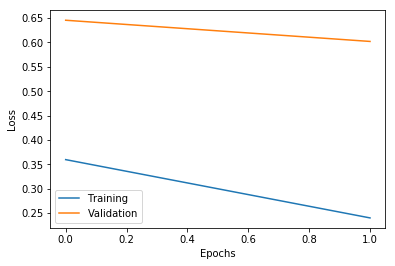

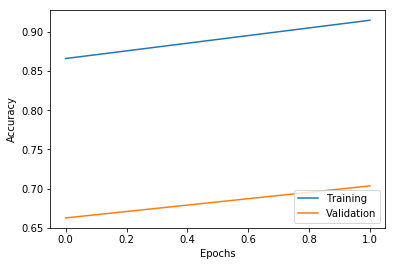

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

**Step 4.** Evaluate the accuracy on test data.

In [78]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

('Test Loss:', 0.6031009864807129)
('Test Accuracy:', 0.7009)


Let us visualize our model Predictions!

In [85]:
import matplotlib.pyplot as plt

%matplotlib inline

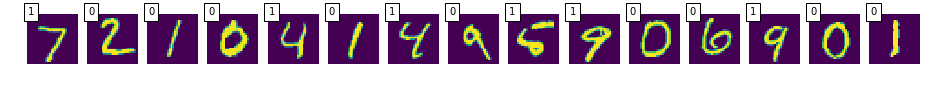

In [80]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

**Question 3.** Can you discuss the performance of the CNN model? What kind of errors is it making?

<h4>
    <strong>
        The performance is pretty bad, predicting that 4's are 7's. Also, it predicted an ugly 5, that looks more like a 6 than anything was a 7, was a 7. Finally, it got a tricky 9 wrong and a clear 9 wrong, showing a lot of room for improvement. 
    </strong>
</h4>    

**Question 4.** Run the training for 10 epochs. How did it impact the accuracy?

In [81]:
nb_epoch = 10

hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print '\nTest Loss:', loss
print 'Test Accuracy:', accuracy


Train on 26265 samples, validate on 10000 samples
Epoch 1/10
26265/26265 [==============================] - 4s 154us/step - loss: 0.2133 - acc: 0.9243 - val_loss: 0.1047 - val_acc: 0.9667
Epoch 2/10
26265/26265 [==============================] - 4s 152us/step - loss: 0.2030 - acc: 0.9277 - val_loss: 0.3219 - val_acc: 0.8614
Epoch 3/10
26265/26265 [==============================] - 4s 156us/step - loss: 0.1917 - acc: 0.9310 - val_loss: 0.1128 - val_acc: 0.9619
Epoch 4/10
26265/26265 [==============================] - 5s 174us/step - loss: 0.1858 - acc: 0.9322 - val_loss: 0.0945 - val_acc: 0.9669
Epoch 5/10
26265/26265 [==============================] - 5s 172us/step - loss: 0.1794 - acc: 0.9363 - val_loss: 0.1239 - val_acc: 0.9565
Epoch 6/10
26265/26265 [==============================] - 4s 171us/step - loss: 0.1836 - acc: 0.9323 - val_loss: 0.1778 - val_acc: 0.9323
Epoch 7/10
26265/26265 [==============================] - 5s 175us/step - loss: 0.1781 - acc: 0.9350 - val_loss: 0.0985 - 

<h4>
    <strong>
        The accuracy was greatly improved jumping from 0.7032 to 0.9702
    </strong>
</h4>    

### Train a more complicated CNN (CNN, model 2)

Now, we will define a more complicated CNN architecture.

In [82]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(128))#this line and next are only difference from above model
model.add(Activation('relu'))# these lines add one layer 

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               692352    
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
__________

In [84]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
nb_epoch = 2

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test));

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 7s 255us/step - loss: 0.1960 - acc: 0.9274 - val_loss: 0.0920 - val_acc: 0.9724
Epoch 2/2
26265/26265 [==============================] - 7s 261us/step - loss: 0.0922 - acc: 0.9694 - val_loss: 0.0630 - val_acc: 0.9804


In [85]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

('Test score:', 0.06298795524276793)
('Test accuracy:', 0.9804)


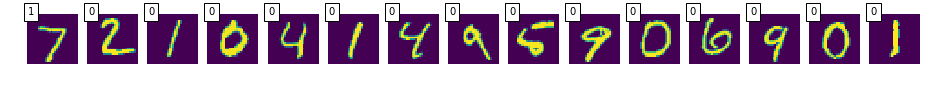

In [86]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

Wow! We have lifted the accuracy from 70.4% to 98.33%. This model can figure out the two "4"s  are not 7, but still be confused by pesky "9"! 

**Question 5.** Can you explain the architecture of this CNN (model 2) and how is it different from the first CNN you trained (model 1)? Compare their performance by looking at the visualizstions.

<h4>
    <strong>
        Model 2 has 8 layers, 2 more than model 1, the two additional layers are a dense layer and an activation layer. Additionally, the shape of the max_pooling2d layer is larger. Along with the flatten_2, dense_2, and activation_4 layers which are all larger than the layers they correspond to in model 1.
        <br><br>
        Finally, model 2 takes 692,352 parameters in the dense_2 layer which corresponds to the dense_1 layer in model 1 which only takes 66 parameters.
        <br><br>
        Model 2 was able to deal with the 4's and 9's from our training set that gave model 1 so much trouble.
    </strong>
</h4>

### Adding more convolutional layers and MaxPooling layers (CNN, model 3)

Now, we will define an even more complicated CNN architecture.

In [87]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1602      
__________

In [89]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 10s 376us/step - loss: 0.2590 - acc: 0.8963 - val_loss: 0.1158 - val_acc: 0.9701
Epoch 2/2
26265/26265 [==============================] - 8s 307us/step - loss: 0.1081 - acc: 0.9642 - val_loss: 0.0750 - val_acc: 0.9777


In [90]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

('Test score:', 0.07496998616158962)
('Test accuracy:', 0.9777)


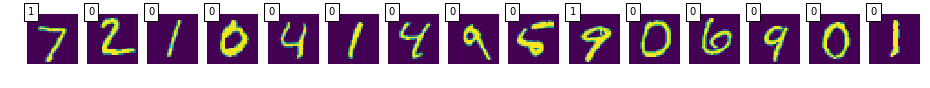

In [91]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

Another 0.2 % lift from 97.8% to 98.0%. This model sees clearly "9" is different than "7"! 

### Wrapping all the code together and play with hyperparameters

The code below wraps up the pieces of codes above into a single function and allows you to play with the hyperparameters by changing the arguments.


In [92]:
# Function for constructing the convolution neural network
# Feel free to add parameters, if you want

def build_model(num_conv = 1, conv_activation = "relu", num_dense = 1, dense_activation  = "relu", 
               dropout = True, max_pooling = True):
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation(conv_activation))
    
    for i in range(num_conv-1):
        model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
        model.add(Activation(conv_activation))
        
    if max_pooling is True:
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
        
    if dropout is True:
        model.add(Dropout(0.25))
    
    model.add(Flatten())

    if dropout is True:
        model.add(Dropout(0.5))
    
    for i in range(num_dense-1):
        model.add(Dense(128))
        model.add(Activation(dense_activation))
        
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, Y_test))
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(num_conv , 'convolutional layers,', num_dense, "dense layers")
    if max_pooling: print("With max pooling")
    if dropout: print("With dropout")
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)

    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

An example of running this function

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 7s 254us/step - loss: 0.2215 - acc: 0.9190 - val_loss: 0.0957 - val_acc: 0.9750
Epoch 2/2
26265/26265 [==============================] - 6s 222us/step - loss: 0.1254 - acc: 0.9563 - val_loss: 0.0759 - val_acc: 0.9782
(1, 'convolutional layers,', 1, 'dense layers')
With max pooling
With dropout
('Test score:', 0.07590367532745004)
('Test accuracy:', 0.9782)


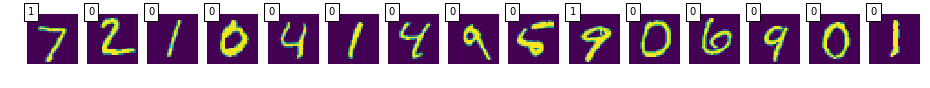

In [93]:
# Here is an example of running build_model() with default hyperparameters
build_model()

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 57s 2ms/step - loss: 0.2567 - acc: 0.8903 - val_loss: 0.0776 - val_acc: 0.9750
Epoch 2/2
26265/26265 [==============================] - 57s 2ms/step - loss: 0.1121 - acc: 0.9599 - val_loss: 0.0685 - val_acc: 0.9779
(3, 'convolutional layers,', 3, 'dense layers')
With max pooling
With dropout
('Test score:', 0.068534607073199)
('Test accuracy:', 0.9779)


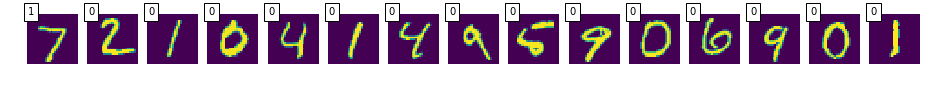

In [94]:
# Here is an example of running build_model() with new hyperparameters
build_model(num_conv = 3, num_dense = 3)

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 7s 272us/step - loss: 0.2293 - acc: 0.9148 - val_loss: 0.0894 - val_acc: 0.9779
Epoch 2/2
26265/26265 [==============================] - 6s 236us/step - loss: 0.1259 - acc: 0.9570 - val_loss: 0.0764 - val_acc: 0.9785
(1, 'convolutional layers,', 1, 'dense layers')
With max pooling
With dropout
('Test score:', 0.07641848569065332)
('Test accuracy:', 0.9785)
1 loop, best of 1: 14.7 s per loop


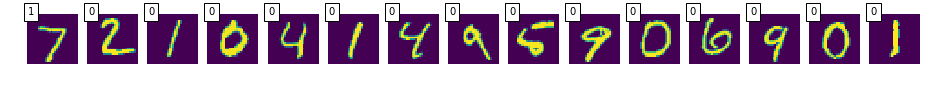

In [95]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model()

**Question 6.** Try to change some of the **hyperparameters** without exploding the computational resources on your computer. 
What is the best accuracy you can get? How many parameters are there of each model? How long does the training take? Maybe increase the amount of data used? What does that do to the accuracy and training time? 

In [102]:
sevens = np.where(y_train == 7)[0].tolist()
not_sevens = np.where(y_train != 7)[0].tolist()
num_keepers = 30000
not_sevens = np.random.choice(not_sevens, num_keepers, replace=True).tolist()

subset = sevens + not_sevens
np.random.shuffle(subset) # shuffle the input

X_train = X_train[subset, :, :]
y_train = y_train[subset]

In [103]:
from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Create labels:

# Converting the labels to binary classification(Seven =1,Not Seven=0)
Y_train = (y_train == 7).astype(int)
Y_test = (y_test == 7).astype(int)

# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

Train on 36265 samples, validate on 10000 samples
Epoch 1/10
36265/36265 [==============================] - 51s 1ms/step - loss: 0.4801 - acc: 0.8263 - val_loss: 0.3435 - val_acc: 0.8972
Epoch 2/10
36265/36265 [==============================] - 56s 2ms/step - loss: 0.4605 - acc: 0.8272 - val_loss: 0.3445 - val_acc: 0.8972
Epoch 3/10
36265/36265 [==============================] - 52s 1ms/step - loss: 0.4603 - acc: 0.8272 - val_loss: 0.3442 - val_acc: 0.8972
Epoch 4/10
36265/36265 [==============================] - 51s 1ms/step - loss: 0.4603 - acc: 0.8272 - val_loss: 0.3447 - val_acc: 0.8972
Epoch 5/10
36265/36265 [==============================] - 50s 1ms/step - loss: 0.4604 - acc: 0.8272 - val_loss: 0.3471 - val_acc: 0.8972
Epoch 6/10
36265/36265 [==============================] - 50s 1ms/step - loss: 0.4602 - acc: 0.8272 - val_loss: 0.3519 - val_acc: 0.8972
Epoch 7/10
36265/36265 [==============================] - 50s 1ms/step - loss: 0.4602 - acc: 0.8272 - val_loss: 0.3474 - val_acc

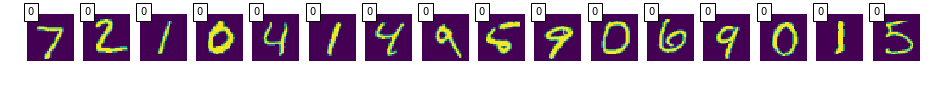

In [104]:
def build_model(num_conv = 2, conv_activation = "relu", num_dense = 3, dense_activation  = "relu", 
               dropout = True, max_pooling = True):

    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation(conv_activation))

    for i in range(num_conv-1):
        model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
        model.add(Activation(conv_activation))

    if max_pooling is True:
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    if dropout is True:
        model.add(Dropout(0.25))

    model.add(Flatten())

    if dropout is True:
        model.add(Dropout(0.5))

    for i in range(num_dense-1):
        model.add(Dense(128))
        model.add(Activation(dense_activation))

    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=10,verbose=1,
              validation_data=(X_test, Y_test))


    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(num_conv , 'convolutional layers,', num_dense, "dense layers")
    if max_pooling: print("With max pooling")
    if dropout: print("With dropout")
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    slice = 16
    predicted = model.predict(X_test[:slice]).argmax(-1)

    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

#runs model
%timeit -n1 -r1 build_model()

In [105]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1602      
__________

<h4>
    <strong>
        What is the best accuracy you can get? How many parameters are there of each model? How long does the training take? Maybe increase the amount of data used? What does that do to the accuracy and training time?
    </strong></h4>
    <h3>The best accuracy I've been able to obtain is 98%<br>I'm somewhat confused by this question, but in anattempt to answer. There are 2 convolutional layers, and 3 dense layers. The training took 5min 59s.<br><br>After updating the sample set to 36265, There was the same number of layers, the accuracy obtained was 89% a significant decrease from 98%, and the training took 8min 38s.</h3>



#### Question 7 (20% of the grade)

Can you train a model to output 10 classes instead of 2 binary classes? We can use this model to classify images into 10 digits of the mnist data set. Again, we will only train our model on a subset of the training data. The following steps will help you to build such a model.

    * 1. Select 20,000 examples randomly from X_train, since we want all 10 digits present in our training data.
    * 2. Convert Y_train and Y_test to categorical.
    * 3. Call the build_model() on the X_train and Y_train.

In [87]:
%pylab inline

import numpy as np
np.random.seed(123)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

Populating the interactive namespace from numpy and matplotlib


/Users/scttohara/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [88]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [89]:
#np.random.choice(x_train, 20000)

In [90]:
print(x_train.shape)

(60000, 28, 28)


In [91]:
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

print(x_train.shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

(60000, 1, 28, 28)


In [92]:
print(y_train.shape)

(60000,)


In [93]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [94]:
#n = 20000  # for 2 random indices
#index = np.random.choice(x_train.shape[0], n, replace=False)  

In [95]:
 #print(x_train.shape)

In [96]:
#Check shape of our class label data again
#print(y_train.shape)

(None, 32, 26, 26)
Epoch 1/10
60000/60000 [==============================] - 111s 2ms/step - loss: 0.2464 - acc: 0.9253
Epoch 2/10
60000/60000 [==============================] - 111s 2ms/step - loss: 0.1009 - acc: 0.9707
Epoch 3/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0773 - acc: 0.9773
Epoch 4/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0630 - acc: 0.9811
Epoch 5/10
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0556 - acc: 0.9829
Epoch 6/10
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0501 - acc: 0.9841
Epoch 7/10
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0453 - acc: 0.9858
Epoch 8/10
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0374 - acc: 0.9883
Epoch 9/10
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0380 - acc: 0.9883
Epoch 10/10
60000/60000 [==============================] - 115s 2ms/step

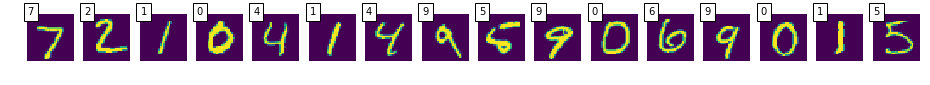

In [97]:
def build_model(num_conv = 2, conv_activation = "relu", num_dense = 3, dense_activation  = "relu", 
               dropout = True, max_pooling = True):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,28,28), data_format='channels_first'))

    print( model.output_shape)

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1)

#Evaluating the model on the test data    
    score, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(num_conv , 'convolutional layers,', num_dense, "dense layers")
    if max_pooling: print("With max pooling")
    if dropout: print("With dropout")
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    slice = 16
    predicted = model.predict(x_test[:slice]).argmax(-1)

    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

#runs model
%timeit -n1 -r1 build_model()

In [98]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


#### Question 8 (30% of the grade) 

Train a model on CIFAR10 dataset, which is described in https://www.cs.toronto.edu/~kriz/cifar.html. You can load the dataset from Keras, too. CIFAR10 small image classification contains 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

```python
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
```

Again, we will only train our model on a subset of the training data. The following steps will help you to build such a model.

    * 1. Select 20,000 examples randomly from X_train, since we want all 10 categories present in our training data.
    * 2. Convert Y_train and Y_test to categorical.
    * 3. Call the build_model() on the X_train and Y_train.

In [192]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [193]:
print x_train.shape
print x_test.shape
print y_train.shape
print y_test.shape

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [194]:
from keras import backend as K

img_rows, img_cols = 32, 32

if K.image_data_format() == 'channels_first':
    shape_ord = (3, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 3)

# Normalize the images:

x_train = x_train.reshape((x_train.shape[0],) + shape_ord)
x_test = x_test.reshape((x_test.shape[0],) + shape_ord)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

# Converting the classes to its binary categorical form
nb_classes = 10
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [195]:
print(x_train.shape)

(50000, 32, 32, 3)


In [196]:
print(x_test.shape)

(10000, 32, 32, 3)


In [197]:
print(y_train.shape)

(50000, 10)


In [198]:
#convert y train and test
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)

In [199]:
print(y_test.shape)

(10000, 10)


(None, 32, 30, 1)
Epoch 1/20
50000/50000 [==============================] - 66s 1ms/step - loss: 1.8717 - acc: 0.3163
Epoch 2/20
50000/50000 [==============================] - 63s 1ms/step - loss: 1.6598 - acc: 0.4029
Epoch 3/20
50000/50000 [==============================] - 62s 1ms/step - loss: 1.5808 - acc: 0.4326
Epoch 4/20
50000/50000 [==============================] - 61s 1ms/step - loss: 1.5148 - acc: 0.4579
Epoch 5/20
50000/50000 [==============================] - 61s 1ms/step - loss: 1.4583 - acc: 0.4814
Epoch 6/20
50000/50000 [==============================] - 61s 1ms/step - loss: 1.4202 - acc: 0.4949
Epoch 7/20
50000/50000 [==============================] - 62s 1ms/step - loss: 1.3890 - acc: 0.5053
Epoch 8/20
50000/50000 [==============================] - 64s 1ms/step - loss: 1.3525 - acc: 0.5206
Epoch 9/20
50000/50000 [==============================] - 63s 1ms/step - loss: 1.3337 - acc: 0.5251
Epoch 10/20
50000/50000 [==============================] - 64s 1ms/step - loss: 1.

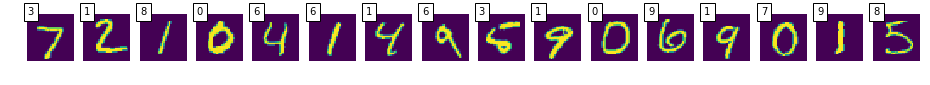

In [200]:
def build_model(num_conv = 1, conv_activation = "relu", num_dense = 2, dense_activation  = "relu", 
               dropout = True, max_pooling = True):
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), data_format='channels_first'))

    print( model.output_shape)

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1)

#Evaluating the model on the test data    
    score, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(num_conv , 'convolutional layers,', num_dense, "dense layers")
    if max_pooling: print("With max pooling")
    if dropout: print("With dropout")
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    slice = 16
    predicted = model.predict(x_test[:slice]).argmax(-1)

    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

#runs model
%timeit -n1 -r1 build_model()

In [201]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 32, 30, 1)         9248      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 30, 28, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 15, 14, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 15, 14, 32)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 6720)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               860288    
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
__________